In [1]:
#Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
import nltk

In [2]:
df = pd.read_json('dataset.json')

In [3]:
#Exploring the dataset
df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,#ElectionDay https://t.co/MXrAxYnTjY https://t...,2016-11-08 18:23:39+00:00,25164,61186,False,796055597594578944
1,Twitter Web Client,We need your vote. Go to the POLLS! Let's cont...,2016-11-08 18:03:49+00:00,23878,62105,False,796050609254395904
2,Twitter Web Client,VOTE TODAY! Go to https://t.co/MXrAxYnTjY to f...,2016-11-08 16:39:36+00:00,29314,67452,False,796029413318082560
3,Twitter for Android,TODAY WE MAKE AMERICA GREAT AGAIN!,2016-11-08 11:43:14+00:00,344806,573283,False,795954831718498304
4,Twitter for iPhone,Today we are going to win the great state of M...,2016-11-08 06:42:36+00:00,17323,54396,False,795879172795203584


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8028 entries, 0 to 8027
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   source          8028 non-null   object             
 1   text            8028 non-null   object             
 2   created_at      8028 non-null   datetime64[ns, UTC]
 3   retweet_count   8028 non-null   int64              
 4   favorite_count  8028 non-null   int64              
 5   is_retweet      8028 non-null   bool               
 6   id_str          8028 non-null   int64              
dtypes: bool(1), datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 384.3+ KB


In [5]:
df.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Twitter for Android',
       'Periscope', 'Twitter for iPad', 'TweetDeck', 'Twitter Ads',
       'Media Studio', 'Instagram', 'Mobile Web (M5)',
       'Twitter Mirror for iPad', 'Twitter QandA', 'Facebook',
       'Twitter for BlackBerry'], dtype=object)

In [6]:
# Only tweets from iPhone and Android are considered in this project
df = df[df.source.isin(['Twitter for iPhone','Twitter for Android'])]
df.source.unique()

array(['Twitter for iPhone', 'Twitter for Android'], dtype=object)

In [7]:
df.shape

(6524, 7)

In [8]:
df['created_at_est'] = df['created_at'].dt.tz_convert('US/Eastern')
df['hour'] = df['created_at_est'].dt.hour

In [9]:
def simplify_source_name(source):
    if source == 'Twitter for iPhone':
        return "iPhone"
    else:
        return "Android"

In [10]:
df['source'] = df['source'].apply(simplify_source_name)

In [11]:
df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,created_at_est,hour
0,iPhone,#ElectionDay https://t.co/MXrAxYnTjY https://t...,2016-11-08 18:23:39+00:00,25164,61186,False,796055597594578944,2016-11-08 13:23:39-05:00,13
3,Android,TODAY WE MAKE AMERICA GREAT AGAIN!,2016-11-08 11:43:14+00:00,344806,573283,False,795954831718498304,2016-11-08 06:43:14-05:00,6
4,iPhone,Today we are going to win the great state of M...,2016-11-08 06:42:36+00:00,17323,54396,False,795879172795203584,2016-11-08 01:42:36-05:00,1
5,iPhone,RT @DonaldJTrumpJr: Thanks New Hampshire!!! \n...,2016-11-08 04:29:10+00:00,10626,0,True,795845594032013312,2016-11-07 23:29:10-05:00,23
6,iPhone,RT @detroitnews: .@IvankaTrump in Michigan: ‘T...,2016-11-08 04:27:18+00:00,6982,0,True,795845126744604672,2016-11-07 23:27:18-05:00,23


Overall, there were 2283 tweets from iPhone, and 4241 tweets from Android.

What time of day did the tweets occur?

In [12]:
def percentage_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of percentage with one decimal.
    """
    return '{:.0f}{}'.format(x * 100, '%') #old syntax: '%1.0f%' % (x * 100)

In [13]:
source_by_hour = df.groupby(['source','hour'])['hour'].size().reset_index(name='counts')

android_total = source_by_hour[source_by_hour['source']=="Android"]['counts'].sum()
iphone_total = source_by_hour[source_by_hour['source']=="iPhone"]['counts'].sum()
source_by_hour['separate_percentage'] = np.where(source_by_hour['source']== "Twitter for Android", source_by_hour['counts']/android_total, source_by_hour['counts']/iphone_total)

source_by_hour.head()

,source,hour,counts,separate_percentage
0,Android,0,141,0.061761
1,Android,1,75,0.032852
2,Android,2,30,0.013141
3,Android,3,48,0.021025
4,Android,4,70,0.030661


<Figure size 432x288 with 0 Axes>

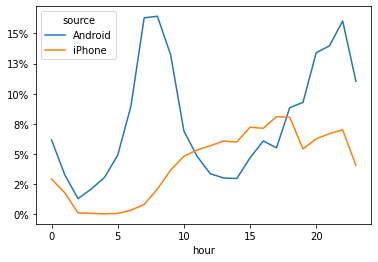

In [14]:
from matplotlib.ticker import FuncFormatter #Call formatter function to format tick values
fig = plt.figure()

source_by_hour_pivot = source_by_hour.pivot(index = 'hour', columns = 'source', values = 'separate_percentage')

ax = source_by_hour_pivot.plot()
formatter = FuncFormatter(percentage_format)
ax.yaxis.set_major_formatter(formatter)

Person on the Android did a lot more tweeting in the morning, while the people posted from the iPhone more in the 'Office hour' and early evening.

Another place we can spot a difference is in Trump’s anachronistic behavior of “manually retweeting” people by copy-pasting their tweets, then surrounding them with quotation marks:

In [15]:
df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,created_at_est,hour
0,iPhone,#ElectionDay https://t.co/MXrAxYnTjY https://t...,2016-11-08 18:23:39+00:00,25164,61186,False,796055597594578944,2016-11-08 13:23:39-05:00,13
3,Android,TODAY WE MAKE AMERICA GREAT AGAIN!,2016-11-08 11:43:14+00:00,344806,573283,False,795954831718498304,2016-11-08 06:43:14-05:00,6
4,iPhone,Today we are going to win the great state of M...,2016-11-08 06:42:36+00:00,17323,54396,False,795879172795203584,2016-11-08 01:42:36-05:00,1
5,iPhone,RT @DonaldJTrumpJr: Thanks New Hampshire!!! \n...,2016-11-08 04:29:10+00:00,10626,0,True,795845594032013312,2016-11-07 23:29:10-05:00,23
6,iPhone,RT @detroitnews: .@IvankaTrump in Michigan: ‘T...,2016-11-08 04:27:18+00:00,6982,0,True,795845126744604672,2016-11-07 23:27:18-05:00,23


In [16]:
print(df.text.str.startswith('"', na = False).sum())
df.text[df.text.str.startswith('"', na = False)]

2428


53      "The Clinton Campaign at Obama Justice" #Drain...
70      "It pays to have friends in high places- like ...
73      "@PYNance: Evangelical women live at #trumptow...
74      "@Ravenrantz: #Billygraham's grand daughter #S...
102     "@slh: I follow Mr.Trump at all of his rallies...
                              ...                        
8023    "@yankzpat: HEY! I hope to meet @realDonaldTru...
8024    "@VanityFair: Donald Trump has constructed a w...
8025    "@entreprenershp: As long as you’re going to b...
8026    "@Great: "Money was never a big motivation for...
8027    "@WSJPolitics: Donald Trump's poll numbers wou...
Name: text, Length: 2428, dtype: object

In [17]:
df.loc[53]

source                                                       iPhone
text              "The Clinton Campaign at Obama Justice" #Drain...
created_at                                2016-11-04 16:17:22+00:00
retweet_count                                                  7487
favorite_count                                                15001
is_retweet                                                    False
id_str                                           794574267878928384
created_at_est                            2016-11-04 12:17:22-04:00
hour                                                             12
Name: 53, dtype: object

In [18]:
df.loc[8023]

source                                                      Android
text              "@yankzpat: HEY! I hope to meet @realDonaldTru...
created_at                                2015-06-01 09:54:51+00:00
retweet_count                                                    10
favorite_count                                                   36
is_retweet                                                    False
id_str                                           605311537255956480
created_at_est                            2015-06-01 05:54:51-04:00
hour                                                              5
Name: 8023, dtype: object

In [19]:
quote_tweet = df.copy()

In [20]:
# “manually retweeting” by surrounding tweets with quotation marks
quote_tweet['quoted'] = np.where(quote_tweet.text.str.startswith('"', na = False),"Quoted","Not Quoted")

<AxesSubplot:xlabel='source', ylabel='Number of tweets'>

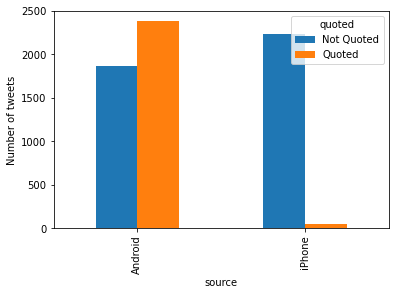

In [21]:
quote_count = quote_tweet.groupby(['source','quoted'])['quoted'].count()
quote_count.unstack().plot(kind="bar", stacked=False, ylabel= "Number of tweets") 
#Person on Android had far more quoted tweet than that on iPhone

In [22]:
""" Since the quoted tweets contain text from followers 
which may not be representative of Trump’s own tweets, 
I will fitler them out """
quote_tweet.drop(quote_tweet[quote_tweet.quoted == "Quoted"].index, inplace=True)

In [23]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer(strip_handles=True, reduce_len=True)
quote_tweet["tokenized_text"] = quote_tweet['text'].apply(tt.tokenize)

In [24]:
quote_tweet.tokenized_text[3]

['TODAY', 'WE', 'MAKE', 'AMERICA', 'GREAT', 'AGAIN', '!']

In [25]:
def replace_link_tag_func(tokenized_text):
    pref_list = ['#', 'http','@'] 

    text = ['Link' if token.startswith(tuple(pref_list)) else token for token in tokenized_text] 
    return text

In [26]:
quote_tweet['replace_link_tag'] = quote_tweet['tokenized_text'].apply(replace_link_tag_func)

In [27]:
quote_tweet.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,created_at_est,hour,quoted,tokenized_text,replace_link_tag
0,iPhone,#ElectionDay https://t.co/MXrAxYnTjY https://t...,2016-11-08 18:23:39+00:00,25164,61186,False,796055597594578944,2016-11-08 13:23:39-05:00,13,Not Quoted,"[#ElectionDay, https://t.co/MXrAxYnTjY, https:...","[Link, Link, Link]"
3,Android,TODAY WE MAKE AMERICA GREAT AGAIN!,2016-11-08 11:43:14+00:00,344806,573283,False,795954831718498304,2016-11-08 06:43:14-05:00,6,Not Quoted,"[TODAY, WE, MAKE, AMERICA, GREAT, AGAIN, !]","[TODAY, WE, MAKE, AMERICA, GREAT, AGAIN, !]"
4,iPhone,Today we are going to win the great state of M...,2016-11-08 06:42:36+00:00,17323,54396,False,795879172795203584,2016-11-08 01:42:36-05:00,1,Not Quoted,"[Today, we, are, going, to, win, the, great, s...","[Today, we, are, going, to, win, the, great, s..."
5,iPhone,RT @DonaldJTrumpJr: Thanks New Hampshire!!! \n...,2016-11-08 04:29:10+00:00,10626,0,True,795845594032013312,2016-11-07 23:29:10-05:00,23,Not Quoted,"[RT, :, Thanks, New, Hampshire, !, !, !, #NH, ...","[RT, :, Thanks, New, Hampshire, !, !, !, Link,..."
6,iPhone,RT @detroitnews: .@IvankaTrump in Michigan: ‘T...,2016-11-08 04:27:18+00:00,6982,0,True,795845126744604672,2016-11-07 23:27:18-05:00,23,Not Quoted,"[RT, :, ., in, Michigan, :, ‘, This, is, your,...","[RT, :, ., in, Michigan, :, ‘, This, is, your,..."


In [28]:
# “manually retweeting” by surrounding tweets with quotation marks
quote_tweet['link_tag'] = quote_tweet['replace_link_tag'].apply(lambda x: 'Link' in x)

In [29]:
quote_tweet.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,created_at_est,hour,quoted,tokenized_text,replace_link_tag,link_tag
0,iPhone,#ElectionDay https://t.co/MXrAxYnTjY https://t...,2016-11-08 18:23:39+00:00,25164,61186,False,796055597594578944,2016-11-08 13:23:39-05:00,13,Not Quoted,"[#ElectionDay, https://t.co/MXrAxYnTjY, https:...","[Link, Link, Link]",True
3,Android,TODAY WE MAKE AMERICA GREAT AGAIN!,2016-11-08 11:43:14+00:00,344806,573283,False,795954831718498304,2016-11-08 06:43:14-05:00,6,Not Quoted,"[TODAY, WE, MAKE, AMERICA, GREAT, AGAIN, !]","[TODAY, WE, MAKE, AMERICA, GREAT, AGAIN, !]",False
4,iPhone,Today we are going to win the great state of M...,2016-11-08 06:42:36+00:00,17323,54396,False,795879172795203584,2016-11-08 01:42:36-05:00,1,Not Quoted,"[Today, we, are, going, to, win, the, great, s...","[Today, we, are, going, to, win, the, great, s...",True
5,iPhone,RT @DonaldJTrumpJr: Thanks New Hampshire!!! \n...,2016-11-08 04:29:10+00:00,10626,0,True,795845594032013312,2016-11-07 23:29:10-05:00,23,Not Quoted,"[RT, :, Thanks, New, Hampshire, !, !, !, #NH, ...","[RT, :, Thanks, New, Hampshire, !, !, !, Link,...",True
6,iPhone,RT @detroitnews: .@IvankaTrump in Michigan: ‘T...,2016-11-08 04:27:18+00:00,6982,0,True,795845126744604672,2016-11-07 23:27:18-05:00,23,Not Quoted,"[RT, :, ., in, Michigan, :, ‘, This, is, your,...","[RT, :, ., in, Michigan, :, ‘, This, is, your,...",True


<AxesSubplot:xlabel='source', ylabel='Number of tweets'>

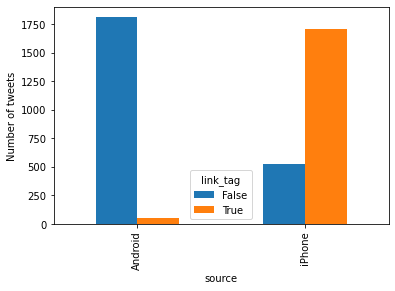

In [30]:
link_count = quote_tweet.groupby(['source','link_tag'])['link_tag'].count()
link_count.unstack().plot(kind="bar", stacked=False, ylabel= "Number of tweets") 
#Person on iPhone had far more tweets with links and tags than that on Android

In [31]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'rt', 'amp', 'realdonaldtrump', '/', '://', '_', 'co', 'trump', 'donald', 'makeamericagreatagain','link','would','u'])

In [32]:
def bag_of_words(ls):
    list_of_word = [i.lower() for i in ls if i.lower() not in stop_words and i.isalpha()]
    return list_of_word

quote_tweet['list_of_words'] = quote_tweet.replace_link_tag.apply(bag_of_words)

In [33]:
quote_tweet.head(3)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,created_at_est,hour,quoted,tokenized_text,replace_link_tag,link_tag,list_of_words
0,iPhone,#ElectionDay https://t.co/MXrAxYnTjY https://t...,2016-11-08 18:23:39+00:00,25164,61186,False,796055597594578944,2016-11-08 13:23:39-05:00,13,Not Quoted,"[#ElectionDay, https://t.co/MXrAxYnTjY, https:...","[Link, Link, Link]",True,[]
3,Android,TODAY WE MAKE AMERICA GREAT AGAIN!,2016-11-08 11:43:14+00:00,344806,573283,False,795954831718498304,2016-11-08 06:43:14-05:00,6,Not Quoted,"[TODAY, WE, MAKE, AMERICA, GREAT, AGAIN, !]","[TODAY, WE, MAKE, AMERICA, GREAT, AGAIN, !]",False,"[today, make, america, great]"
4,iPhone,Today we are going to win the great state of M...,2016-11-08 06:42:36+00:00,17323,54396,False,795879172795203584,2016-11-08 01:42:36-05:00,1,Not Quoted,"[Today, we, are, going, to, win, the, great, s...","[Today, we, are, going, to, win, the, great, s...",True,"[today, going, win, great, state, michigan, go..."


In [34]:
# Top 20 most common tweets on Android 
android_tweets = quote_tweet[quote_tweet.source == 'Android']
android_list_of_word = android_tweets['list_of_words'].to_list()
android_flatten_wordlist = sum(android_list_of_word, [])
android_wordfreqdist = nltk.FreqDist(android_flatten_wordlist)
android_mostcommon = android_wordfreqdist.most_common(20)
print(android_mostcommon)

[('great', 367), ('hillary', 289), ('people', 195), ('big', 172), ('crooked', 156), ('clinton', 136), ('make', 127), ('america', 121), ('many', 119), ('new', 117), ('poll', 116), ('cruz', 113), ('said', 107), ('bad', 104), ('thank', 103), ('get', 99), ('much', 85), ('ted', 85), ('president', 82), ('debate', 80)]


In [37]:
from wordcloud import WordCloud

android_word = pd.Series(android_flatten_wordlist).astype('str')
android_text = ' '.join(android_word)

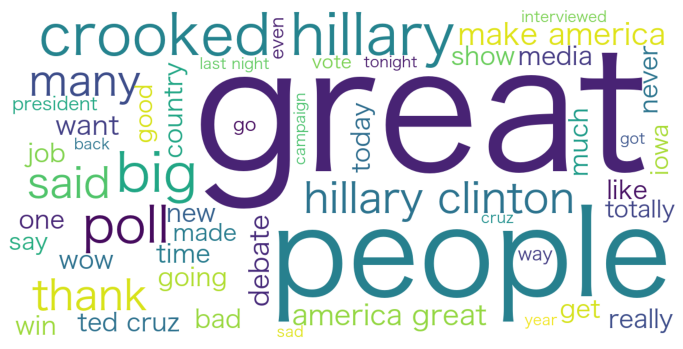

In [38]:
def show_wordcloud(data, title = None):
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=50, 
        scale=3,
        font_path = 'Hiragino Sans GB.ttc',
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(data)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(android_text)

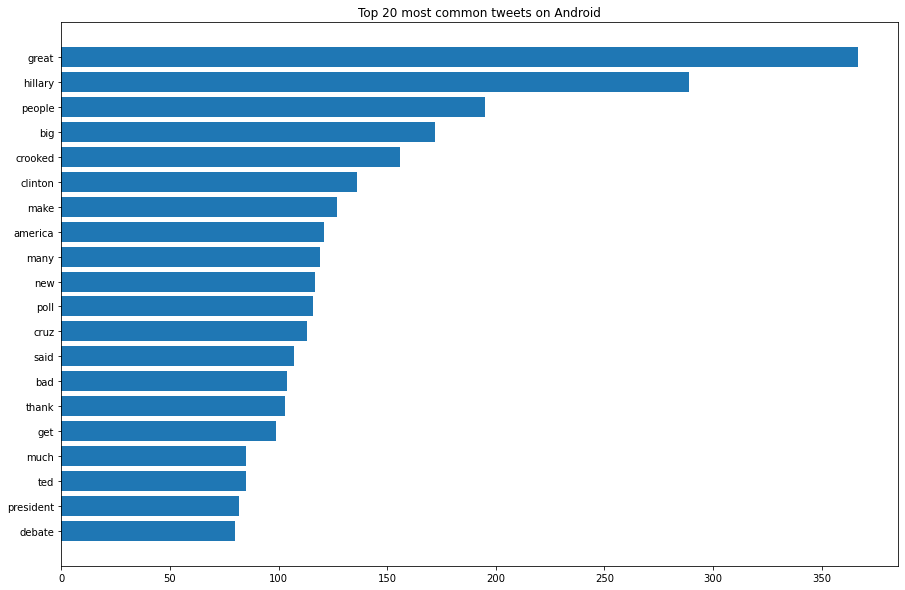

In [39]:
plt.figure(figsize=(15,10))
plt.barh(range(len(android_mostcommon)),[val[1] for val in android_mostcommon], align='center')
plt.yticks(range(len(android_mostcommon)), [val[0] for val in android_mostcommon])
plt.title('Top 20 most common tweets on Android')
plt.gca().invert_yaxis()
plt.show()

[('thank', 615), ('great', 289), ('new', 174), ('join', 163), ('america', 146), ('hillary', 126), ('people', 113), ('clinton', 113), ('poll', 106), ('make', 103), ('tomorrow', 101), ('get', 100), ('tonight', 85), ('vote', 76), ('support', 75), ('today', 74), ('iowa', 66), ('ohio', 65), ('going', 63), ('carolina', 61)]


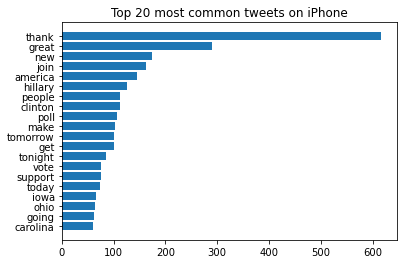

In [40]:
iphone_tweets = quote_tweet[quote_tweet.source == 'iPhone']
iphone_list_of_word = iphone_tweets['list_of_words'].to_list()
iphone_flatten_wordlist = sum(iphone_list_of_word, [])
iphone_wordfreqdist = nltk.FreqDist(iphone_flatten_wordlist)
iphone_mostcommon = iphone_wordfreqdist.most_common(20)
print(iphone_mostcommon)
plt.barh(range(len(iphone_mostcommon)),[val[1] for val in iphone_mostcommon], align='center')
plt.yticks(range(len(iphone_mostcommon)), [val[0] for val in iphone_mostcommon])
plt.title('Top 20 most common tweets on iPhone')
plt.gca().invert_yaxis()
plt.show()

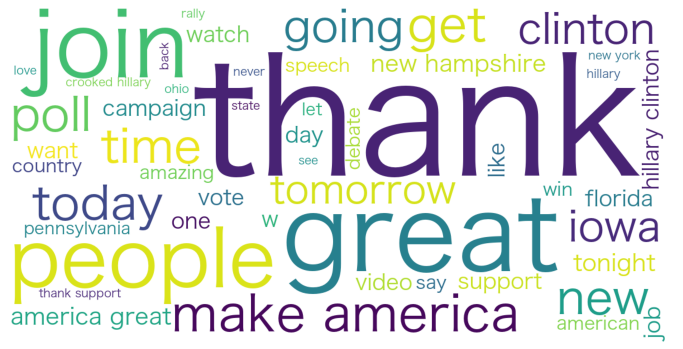

In [41]:
iphone_word = pd.Series(iphone_flatten_wordlist).astype('str')
iphone_text = ' '.join(iphone_word)
show_wordcloud(iphone_text)

In [42]:
android_wordlist = android_word.reset_index(name='words').groupby('words')['words'].count().reset_index(name='counts').sort_values(by=['counts'], ascending=True)
android_wordlist.head()

,words,counts
1778,lake,1
2537,quid,1
2538,quinnipiac,1
2540,quits,1
1250,footprint,1


In [44]:
from nrclex import NRCLex
def emotion_association(word):
    
    emotion = NRCLex(word)
    
    return emotion.affect_list

In [45]:
android_wordlist['sentiment'] = android_wordlist['words'].apply(emotion_association)

In [47]:
android_df = android_wordlist[android_wordlist.sentiment.str.len() != 0].reset_index()
android_df.head()

,index,words,counts,sentiment
0,1247,foolish,1,[negative]
1,1231,flow,1,[positive]
2,2560,rambling,1,[negative]
3,1228,flood,1,[fear]
4,2530,quest,1,"[anticipation, positive]"


In [48]:
flattened_col = pd.DataFrame([(index, value) for (index, values) in android_df['sentiment'].iteritems() for value in values],
                             columns=['index', 'sentiment']).set_index('index')
android_df = android_df.drop('sentiment',axis = 1).join(flattened_col)

In [49]:
android_df.head()

,index,words,counts,sentiment
0,1247,foolish,1,negative
1,1231,flow,1,positive
2,2560,rambling,1,negative
3,1228,flood,1,fear
4,2530,quest,1,anticipation


In [72]:
android_summary = android_df.groupby('sentiment')['counts'].sum().reset_index(name='android_count')
android_summary

,sentiment,android_count
0,anger,957
1,anticipation,1002
2,disgust,636
3,fear,825
4,joy,775
5,negative,1692
6,positive,2017
7,sadness,925
8,surprise,492
9,trust,1398


In [52]:
iphone_wordlist = iphone_word.reset_index(name='words').groupby('words')['words'].count().reset_index(name='counts').sort_values(by=['counts'], ascending=True)
iphone_wordlist.head()

,words,counts
1752,lenses,1
1299,gotten,1
2537,reading,1
2538,readout,1
1294,gonzales,1


In [53]:
iphone_wordlist['sentiment'] = iphone_wordlist['words'].apply(emotion_association)

In [54]:
iphone_df = iphone_wordlist[iphone_wordlist.sentiment.str.len() != 0].reset_index()
iphone_df.head()

,index,words,counts,sentiment
0,2537,reading,1,[positive]
1,2547,rebellion,1,"[anger, disgust, fear]"
2,2559,recovery,1,[positive]
3,1269,gift,1,"[anticipation, joy, positive, surprise]"
4,1304,grab,1,"[anger, negative]"


In [55]:
flattened_iphone_col = pd.DataFrame([(index, value) for (index, values) in iphone_df['sentiment'].iteritems() for value in values],
                             columns=['index', 'sentiment']).set_index('index')
iphone_df = iphone_df.drop('sentiment',axis = 1).join(flattened_iphone_col)

In [73]:
iphone_summary = iphone_df.groupby('sentiment')['counts'].sum().reset_index(name='iphone_count')
iphone_summary

,sentiment,iphone_count
0,anger,560
1,anticipation,806
2,disgust,333
3,fear,531
4,joy,628
5,negative,1004
6,positive,1697
7,sadness,553
8,surprise,333
9,trust,1149


In [82]:
# Measure likelihood of using an emotionally-charged term on Android account relative to the iPhone account 
def emotion_likelihood(df):
    andriod_count = df[0]
    iphone_count = df[1] 
    return (andriod_count - iphone_count)/iphone_count

In [88]:
summary = android_summary.merge(iphone_summary, on='sentiment')
summary

,sentiment,android_count,iphone_count
0,anger,957,560
1,anticipation,1002,806
2,disgust,636,333
3,fear,825,531
4,joy,775,628
5,negative,1692,1004
6,positive,2017,1697
7,sadness,925,553
8,surprise,492,333
9,trust,1398,1149


In [96]:
summary['sentiment_Android_iPhone'] = summary[['android_count','iphone_count']].apply(emotion_likelihood, axis=1)
summary.sort_values(['sentiment_Android_iPhone'],ascending=False, inplace = True)

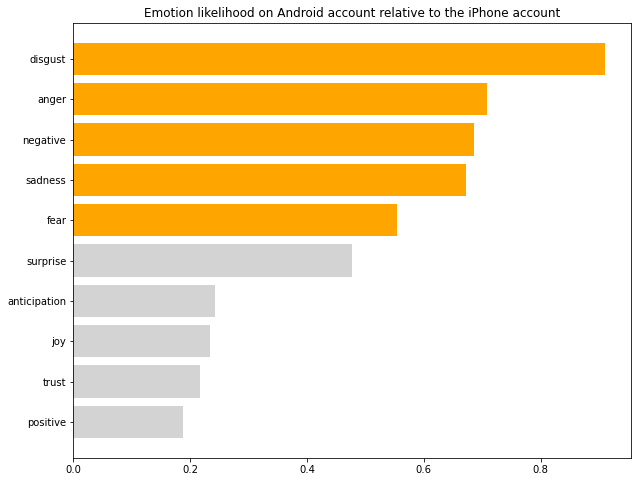

In [108]:
plt.figure(figsize=(10,8))
plt.barh(summary.sentiment,summary.sentiment_Android_iPhone, color=(summary['sentiment_Android_iPhone'] > 0.5).map({True: 'orange', False: 'lightgrey'}))
plt.title('Emotion likelihood on Android account relative to the iPhone account')
plt.gca().invert_yaxis()
plt.show()

From the above graph, Android account used about 50-90% more words related to disgust, anger, sadness, fear and negative sentiments than the iPhone account did